# Run the following

In [1]:
import lambdahat_helpers as lah
import os
import time
import torch
import numpy as np
import pickle
import argparse
import matplotlib.pyplot as plt

[LOADING HYPERPARAMETERS...]
algo : ppo
n_envs : 64
n_steps : 256
epoch : 3
mini_batch_per_epoch : 8
mini_batch_size : 2048
gamma : 0.999
lmbda : 0.95
learning_rate : 0.0005
grad_clip_norm : 0.5
eps_clip : 0.2
value_coef : 0.5
entropy_coef : 0.01
normalize_adv : True
normalize_rew : True
use_gae : True
architecture : impala
recurrent : False
INITIALIZAING ENVIRONMENTS...
INITIALIZAING LOGGER...


In [2]:
directory = f"variance_data"
result_files = os.listdir(directory)[-4:]
results = []
for result_file in result_files:
    results_files = os.listdir(f"{directory}/{result_file}")
    for results_file in results_files:
        with open(f"{directory}/{result_file}/{results_file}", "rb") as f:
            results.append(pickle.load(f))

In [3]:
def result_no_to_artifact_no(result_no):
    if result_no == 0:
        return 2000
    elif result_no == 1:
        return 4000
    elif result_no == 2:
        return 6000
    elif result_no == 3:
        return 8000
def spread(epsilon, gamma):
    spreads = []
    for result_no in range(4):
        result = results[result_no]
        value = result[(result_no_to_artifact_no(result_no), epsilon, gamma)]
        llc_trace = value['llc/trace']
        spread = max(llc_trace[:, -1]) - min(llc_trace[:, -1])
        spreads.append(spread)
    return spreads

In [21]:
def get_common_pairs(results):
    pair_sets = []
    for result in results:
        pairs = {(epsilon, gamma) for _, epsilon, gamma in result.keys()}
        pair_sets.append(pairs)

    common_pairs = set.intersection(*pair_sets)
    return common_pairs

def pareto_optimal_pairs(results, common_pairs):
    # Calculating spreads for each pair
    pair_spreads = {pair: spread(*pair) for pair in common_pairs}
    
    # Finding Pareto optimal pairs
    optimal_pairs = []
    for pair1 in common_pairs:
        is_optimal = True
        for pair2 in common_pairs:
            if pair1 != pair2 and all(s2 <= s1 for s1, s2 in zip(pair_spreads[pair1], pair_spreads[pair2])):
                is_optimal = False
                break
        if is_optimal:
            optimal_pairs.append(pair1)

    return optimal_pairs

def create_spread_table_and_define_optimal_params(results, optimal_pairs):
    table = []
    model_optimals = []

    # Header for the table
    headers = ["Epsilon", "Gamma", "Mean Spread"] + [f"Model {i} Spread" for i in range(len(results))]
    table.append(headers)

    rows = []
    model_mins = [float('inf')] * len(results)
    model_min_pairs = [None] * len(results)

    for pair in optimal_pairs:
        spreads = spread(*pair)
        mean_spread = sum(spreads) / len(spreads)
        row = [pair[0], pair[1], mean_spread] + spreads
        rows.append(row)

        for i, spread_val in enumerate(spreads):
            if spread_val < model_mins[i]:
                model_mins[i] = spread_val
                model_min_pairs[i] = {'epsilon': pair[0], 'gamma': pair[1], 'spread': spread_val}

    rows.sort(key=lambda x: x[2])
    table.extend(rows)

    optimal_params = model_min_pairs  # List of dictionaries with optimal epsilon, gamma, and spread for each model

    return table, optimal_params

def display_table_and_optimal_params(table, optimal_params):
    col_widths = [max(len(str(row[i])) for row in table) for i in range(len(table[0]))]

    for row in table:
        print(" | ".join(str(cell).ljust(col_widths[i]) for i, cell in enumerate(row)))

    print("\nOptimal epsilon and gamma for each model with their spreads:")
    for i, opt in enumerate(optimal_params, start=1):
        print(f"Model {i} optimal: Epsilon={opt['epsilon']}, Gamma={opt['gamma']}, Spread={opt['spread']}")

def get_specific_nth_optimal_parameters(results, optimal_pairs, n_dict):
    # Initialize a structure to hold spreads and parameters for each model
    model_parameters = [[] for _ in results]  # List of lists to hold parameters for each model

    # Populate with all spreads and corresponding parameters
    for pair in optimal_pairs:
        spreads = spread(*pair)
        for i, spread_val in enumerate(spreads):
            model_parameters[i].append({'epsilon': pair[0], 'gamma': pair[1], 'spread': spread_val})

    # Sort each model's parameters by spread and select the specific nth optimal based on n_dict
    specific_nth_optimals = []
    for i, params in enumerate(model_parameters):
        sorted_params = sorted(params, key=lambda x: x['spread'])
        n = n_dict.get(i+1)  # Model numbers are 1-indexed
        if n and len(sorted_params) >= n:
            specific_nth_optimals.append(sorted_params[n-1])  # n-1 because list indices start at 0
        else:
            specific_nth_optimals.append(None)  # In case there are not enough parameters or n not specified

    return specific_nth_optimals

def display_specific_nth_optimal_parameters(specific_nth_optimals):
    print(f"\nSpecific Nth Optimal epsilon and gamma for each model with their spreads:")
    for i, opt in enumerate(specific_nth_optimals, start=1):
        if opt:
            print(f"Model {i} specific nth optimal: Epsilon={opt['epsilon']}, Gamma={opt['gamma']}, Spread={opt['spread']}")
        else:
            print(f"Model {i}: Not enough data for specific nth optimal value or nth value not specified.")

# Example usage
n_dict = {
    1: 1, 
    2: 1, 
    3: 1, 
    4: 4
    }  # Dictionary specifying the nth optimal for each model
common_pairs = get_common_pairs(results)
optimal_pairs = pareto_optimal_pairs(results, common_pairs)
specific_nth_optimal_parameters = get_specific_nth_optimal_parameters(results, optimal_pairs, n_dict)
display_specific_nth_optimal_parameters(specific_nth_optimal_parameters)


optimal_params = specific_nth_optimal_parameters  # List of dictionaries with optimal epsilon, gamma, and spread for each model
print()
# Assuming results is a list of dictionaries for each model

# Initialize a table with updated headers to include both llc/means and Spread
table_headers = ["Model & Optimal Epsilon-Gamma"]
for i in range(1, 5):  # For models 1 to 4
    table_headers.append(f"Model {i} llc/means & Spread")
table = [table_headers]

# Modified function to find llc/means value and spread given epsilon and gamma for a specific model's results
def find_llc_means_and_spread_for_params(model_results, epsilon, gamma):
    for (result_no, eps, gam), value in model_results.items():
        if eps == epsilon and gam == gamma:
            # Assuming it's 'means', adjust if it's 'mean'. Also, adjust for how you calculate spread if necessary.
            llc_means = value['llc/means'][-1]
            spread = max(value['llc/trace'][:, -1]) - min(value['llc/trace'][:, -1])
            return f"{llc_means} & {spread}"
    return "N/A & N/A"  # Return "N/A & N/A" if no matching parameters are found

# Populate the table with both llc/means and Spread
for model_index, params in enumerate(optimal_params, start=1):
    epsilon = params['epsilon']
    gamma = params['gamma']
    row = [f"Model {model_index} ({epsilon}, {gamma})"]
    for result in results:
        llc_means_and_spread = find_llc_means_and_spread_for_params(result, epsilon, gamma)
        row.append(llc_means_and_spread)
    table.append(row)

# Function to display the table
def display_table(table):
    # Determine column widths by finding the max length of items in each column
    col_widths = [max(len(str(item)) for item in col) for col in zip(*table)]
    
    # Print the table row by row
    for row in table:
        print(" | ".join(str(item).ljust(col_widths[idx]) for idx, item in enumerate(row)))

# Display the table
display_table(table)




Specific Nth Optimal epsilon and gamma for each model with their spreads:
Model 1 specific nth optimal: Epsilon=1.0454545454545456e-06, Gamma=90000.0, Spread=60.117218017578125
Model 2 specific nth optimal: Epsilon=1.009090909090909e-06, Gamma=110000.0, Spread=92.089111328125
Model 3 specific nth optimal: Epsilon=9.545454545454546e-07, Gamma=94000.0, Spread=43.41888427734375
Model 4 specific nth optimal: Epsilon=1.0454545454545456e-06, Gamma=108666.66666666666, Spread=116.25384521484375

Model & Optimal Epsilon-Gamma                        | Model 1 llc/means & Spread             | Model 2 llc/means & Spread             | Model 3 llc/means & Spread             | Model 4 llc/means & Spread            
Model 1 (1.0454545454545456e-06, 90000.0)            | 302.9177551269531 & 60.117218017578125 | 646.7584838867188 & 106.52740478515625 | 756.4876098632812 & 207.777587890625   | 743.4144897460938 & 474.3153076171875 
Model 2 (1.009090909090909e-06, 110000.0)            | 313.2135925292969

So I say that until model 3, we just use model 3's optimal params, then we transition to model 4's optimal params. This doesn't cost much spread, and it makes the llcs more easily comparable.

In [59]:
def calculate_spreads_for_model_3(results):
    # Extract common pairs of epsilon and gamma
    common_pairs = get_common_pairs(results)
    
    # Calculate spreads for each common pair, focusing on Model 3
    model_3_spreads = {pair: spread(pair[0], pair[1])[2] for pair in common_pairs}  # Assuming Model 3 is index 2
    return model_3_spreads

def find_nth_optimal_for_model_3(results, n):
    model_3_spreads = calculate_spreads_for_model_3(results)
    
    # Sort the pairs by their spread for Model 3
    sorted_pairs = sorted(model_3_spreads.items(), key=lambda x: x[1])
    
    # Find the second-most optimal pair if it exists
    if len(sorted_pairs) > 1:
        second_optimal_pair, second_optimal_spread = sorted_pairs[n]  # Second item after sorting
    else:
        return "Not enough data for a second-most optimal value."

    return second_optimal_pair, second_optimal_spread

# Using the function
nth_optimal_pair, nth_optimal_spread = find_nth_optimal_for_model_3(results, 4)
print(f"Second-most optimal for Model 3: Epsilon={nth_optimal_pair[0]}, Gamma={nth_optimal_pair[1]}, Spread={nth_optimal_spread}")

# Define the optimal epsilon and gamma for each model
optimal_params = [
    {'epsilon': 1.0454545454545456e-06, 'gamma': 90000.0},  # Model 1
    {'epsilon': 1.009090909090909e-06, 'gamma': 110000.0},  # Model 2
    {'epsilon': nth_optimal_pair[0], 'gamma': nth_optimal_pair[1]},   # Model 3
    {'epsilon': 1.0454545454545456e-06, 'gamma': 103333.33333333333}  # Model 4
]

# Assuming results is a list of dictionaries for each model

# Initialize a table to store llc/means values
# The table will have 5 columns: "Model & Optimal Epsilon-Gamma", "Model 1 llc/means", ..., "Model 4 llc/means"
table = [["Model & Optimal Epsilon-Gamma", "Model 1 llc/means", "Model 2 llc/means", "Model 3 llc/means", "Model 4 llc/means"]]

# Function to find llc/means value given epsilon and gamma for a specific model's results
def find_llc_means_for_params(model_results, epsilon, gamma):
    for (result_no, eps, gam), value in model_results.items():
        if eps == epsilon and gam == gamma:
            return value['llc/means'][-1]  # Assuming it's 'mean', adjust if it's 'means'
    return "N/A"  # Return "N/A" if no matching parameters are found

# Populate the table
for model_index, params in enumerate(optimal_params, start=1):
    epsilon = params['epsilon']
    gamma = params['gamma']
    row = [f"Model {model_index} ({epsilon}, {gamma})"]
    for result in results:
        llc_means = find_llc_means_for_params(result, epsilon, gamma)
        row.append(llc_means)
    table.append(row)

# Function to display the table
def display_table(table):
    # Determine column widths by finding the max length of items in each column
    col_widths = [max(len(str(item)) for item in col) for col in zip(*table)]
    
    # Print the table row by row
    for row in table:
        print(" | ".join(str(item).ljust(col_widths[idx]) for idx, item in enumerate(row)))

# Display the table
display_table(table)


Second-most optimal for Model 3: Epsilon=9.727272727272727e-07, Gamma=99333.33333333333, Spread=65.9306640625
Model & Optimal Epsilon-Gamma                        | Model 1 llc/means | Model 2 llc/means | Model 3 llc/means | Model 4 llc/means
Model 1 (1.0454545454545456e-06, 90000.0)            | 302.91776         | 646.7585          | 756.4876          | 743.4145         
Model 2 (1.009090909090909e-06, 110000.0)            | 313.2136          | 695.5302          | 965.3141          | 856.4627         
Model 3 (9.727272727272727e-07, 99333.33333333333)   | 247.2904          | 583.0356          | 813.17365         | 767.79584        
Model 4 (1.0454545454545456e-06, 103333.33333333333) | 334.61862         | 723.36273         | 896.5805          | 678.9663         


In [6]:
epsilon = 9e-07
gamma = 103333.33333333333

result = results[0]
value = result[(2000, epsilon, gamma)]
llc_trace = value['llc/trace']
min_value_2000 = min(llc_trace[:, -1])
max_value_2000 = max(llc_trace[:, -1])

result = results[1]
value = result[(4000, epsilon, gamma)]
llc_trace = value['llc/trace']
min_value_4000 = min(llc_trace[:, -1])
max_value_4000 = max(llc_trace[:, -1])

result = results[2]
value = result[(6000, epsilon, gamma)]
llc_trace = value['llc/trace']
min_value_6000 = min(llc_trace[:, -1])
max_value_6000 = max(llc_trace[:, -1])

result = results[3]
value = result[(8000, epsilon, gamma)]
llc_trace = value['llc/trace']
min_value_8000 = min(llc_trace[:, -1])
max_value_8000 = max(llc_trace[:, -1])

# Printing the differences between the max of the first and the min of the second
print(f"min(4000) - max(2000): {min_value_4000 - max_value_2000}")
print(f"min(6000) - max(4000): {min_value_6000 - max_value_4000}")
print(f"min(8000) - max(6000): {min_value_8000 - max_value_6000}")


min(4000) - max(2000): 241.55911254882812
min(6000) - max(4000): 166.08660888671875
min(8000) - max(6000): -15.28460693359375


In [7]:
result = results[0]
epsilon_gamma_list = []
for key in result.keys():
    epsilon_gamma_list.append(key[1:])

In [8]:
max_diff = -100
max_diff_eg = None
differences = list()
for eg in epsilon_gamma_list:
    try:
        result = results[2]
        value = result[(6000, eg[0], eg[1])]
        llc_trace = value['llc/trace']
        min_value_6000 = min(llc_trace[:, -1])
        max_value_6000 = max(llc_trace[:, -1])

        result = results[3]
        value = result[(8000, eg[0], eg[1])]
        llc_trace = value['llc/trace']
        min_value_8000 = min(llc_trace[:, -1])
        max_value_8000 = max(llc_trace[:, -1])

        min_max_diff = min_value_8000 - max_value_6000
        if min_max_diff > max_diff:
            max_diff = min_max_diff
            max_diff_eg = eg
        differences.append(min_max_diff)
    except:
        pass
print(max_diff)
print(max_diff_eg)

-15.284607
(9e-07, 103333.33333333333)


# Don't run the following

In [11]:
for result in results:
    for key, value in result.items():
        llc_trace = value['llc/trace']
        spread = max(llc_trace[:, -1]) - min(llc_trace[:, -1])
        

68.184906
68.34962
68.697624
68.98501
68.96322
69.44923
68.87635
69.87722
71.22163
70.96268
72.005974
72.63577
70.68404
70.69504
71.16771
70.839294
67.67648
69.2088
94.63406
94.810455
94.536896
94.72156
95.82959
95.36838
95.46237
95.63571
95.89838
95.69409
96.10104
95.9353
95.26462
96.17828
96.333984
96.55997
94.57626
211.18927
211.12634
211.84033
211.7721
223.40686
213.35535
213.8872
215.2674
216.62524
219.3316
219.80945
211.01978
212.15863
210.4483
211.44244
208.27313
315.526
246.56854
311.17133
249.06714
236.74292
168.90784
163.1684
276.90277
178.60638
286.4909
136.91675
318.01953
258.58813
373.56732
286.79633
292.75745


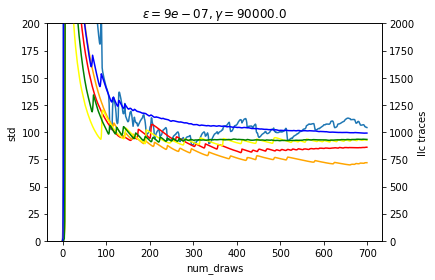

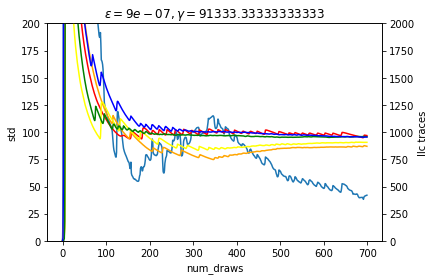

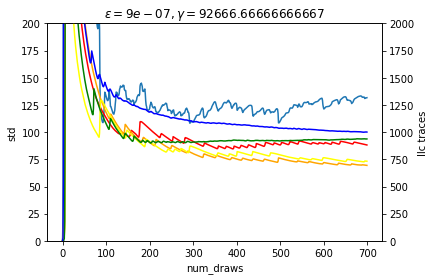

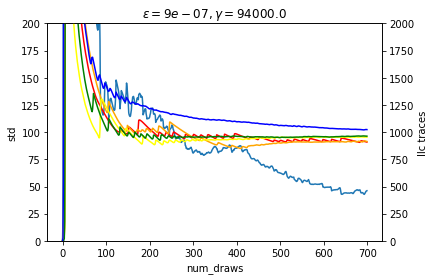

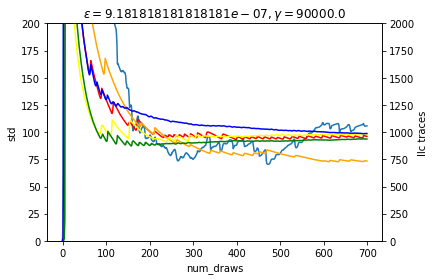

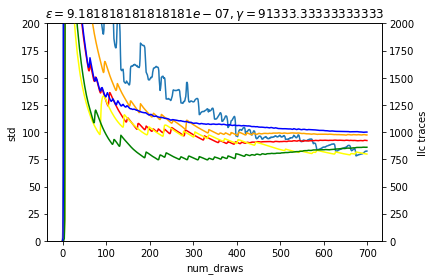

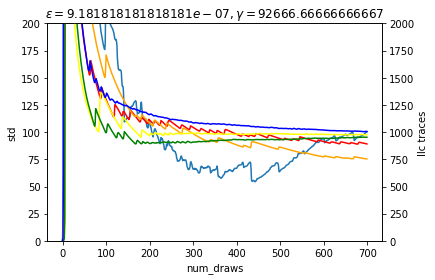

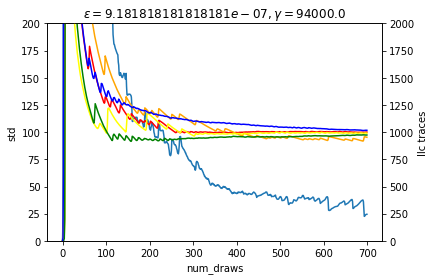

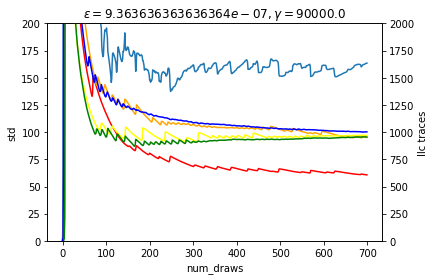

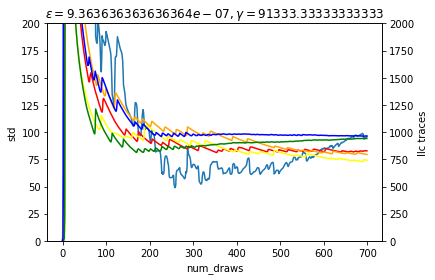

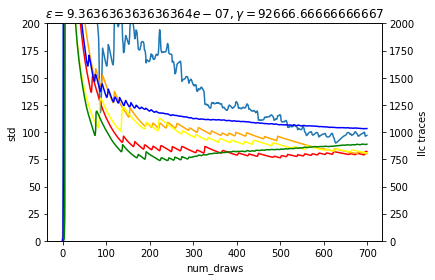

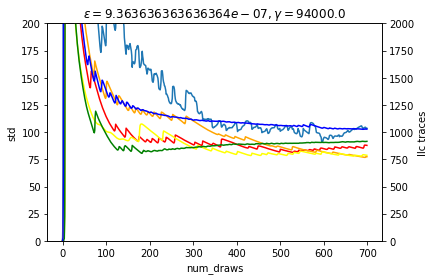

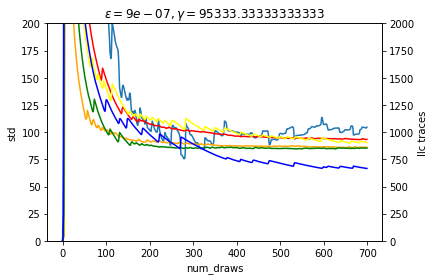

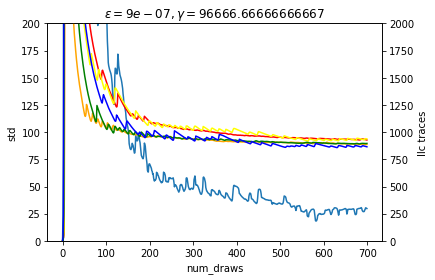

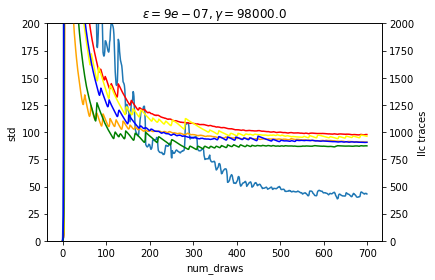

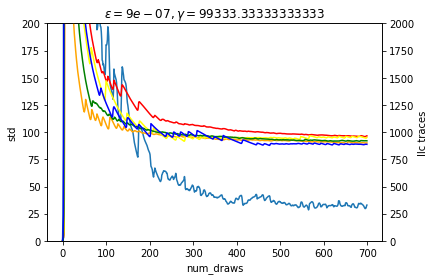

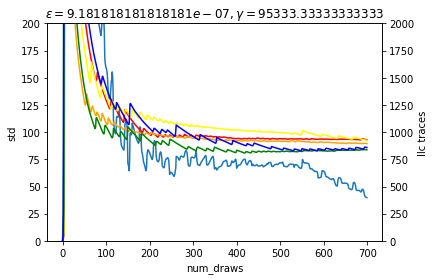

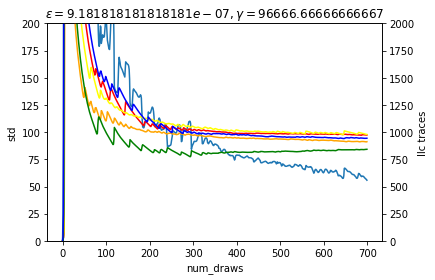

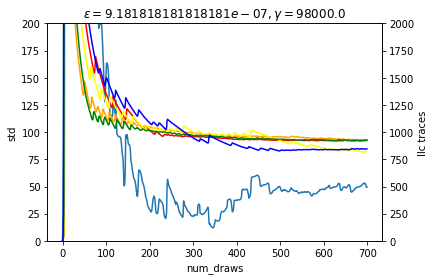

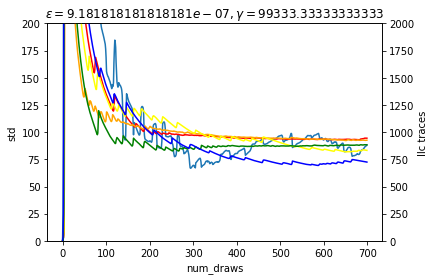

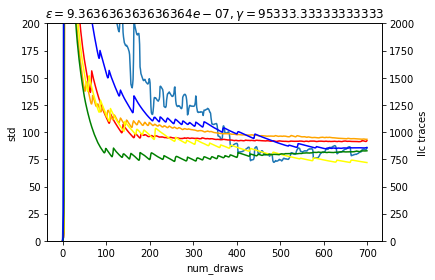

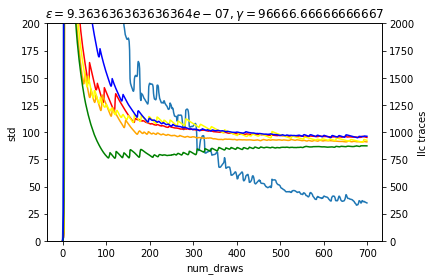

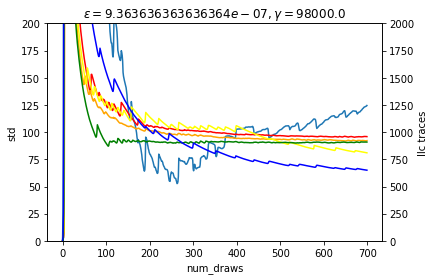

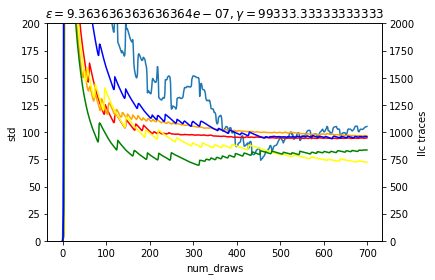

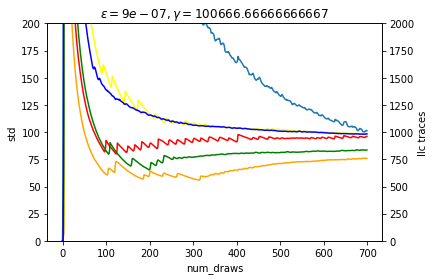

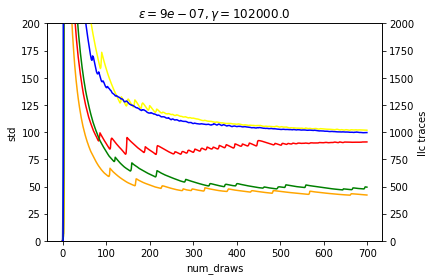

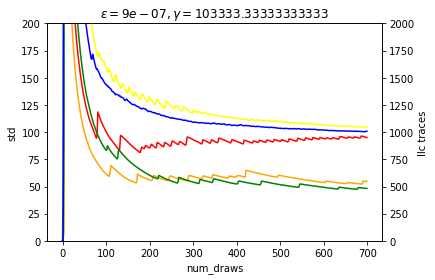

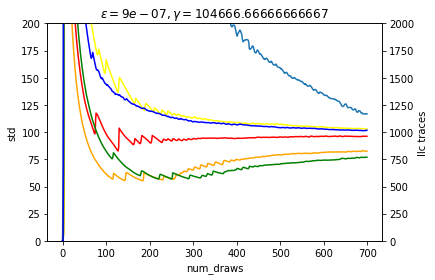

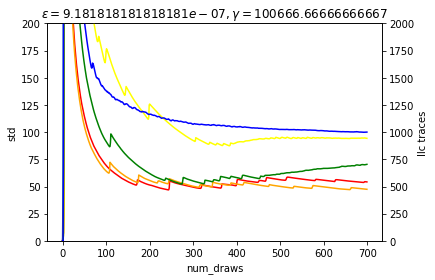

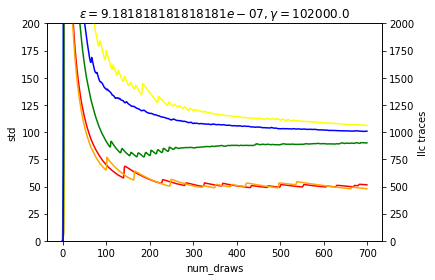

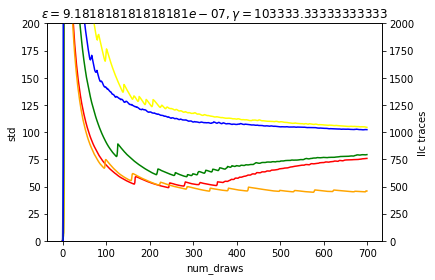

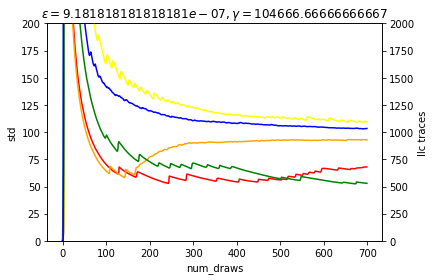

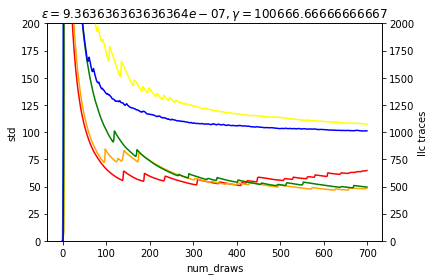

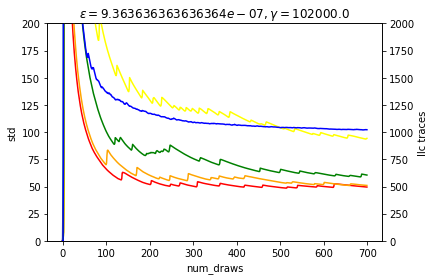

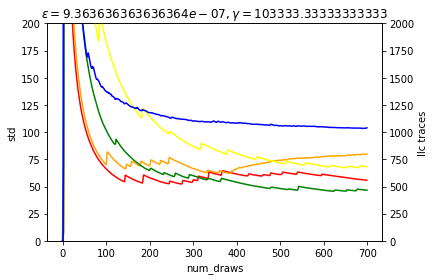

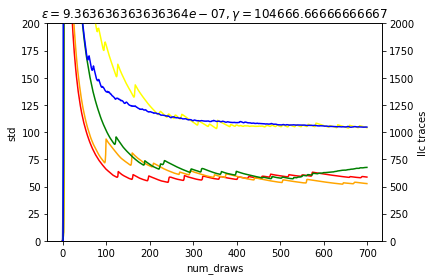

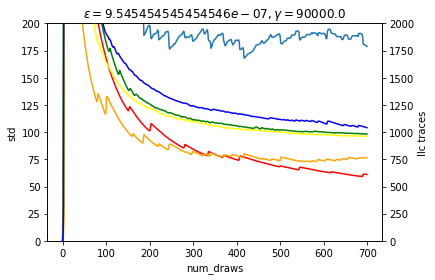

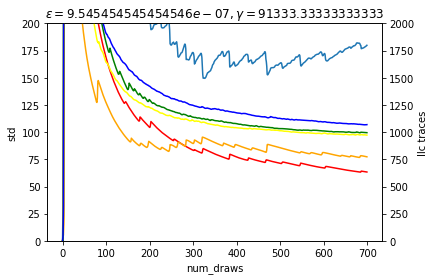

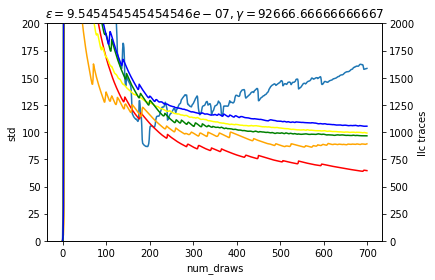

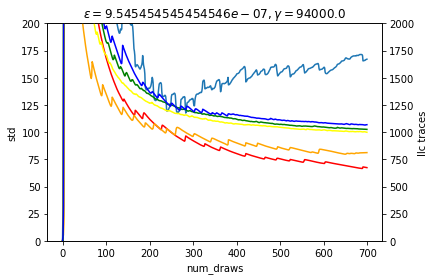

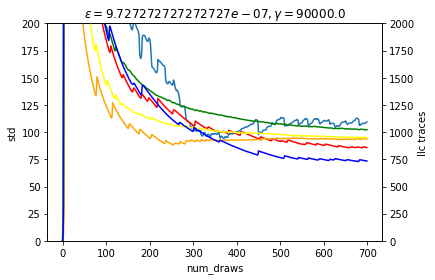

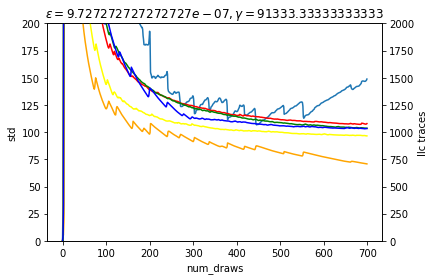

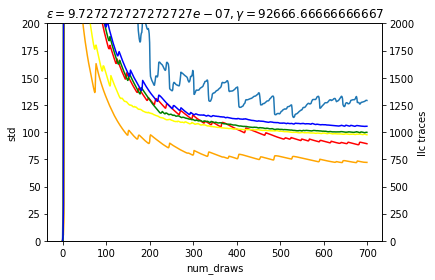

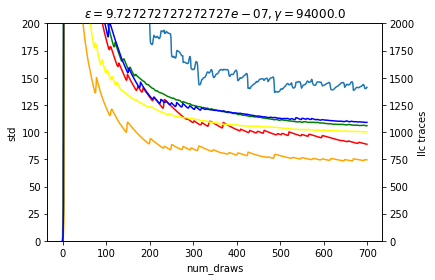

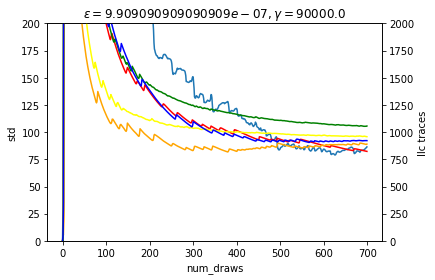

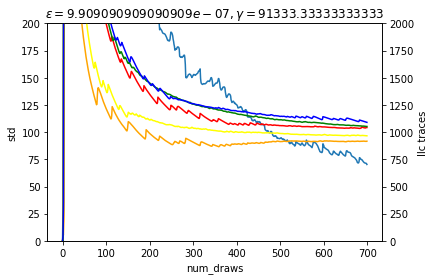

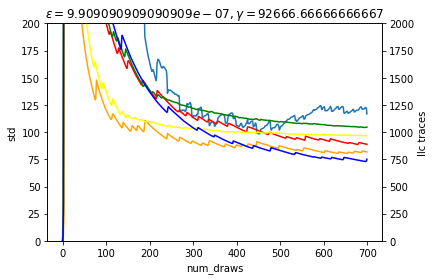

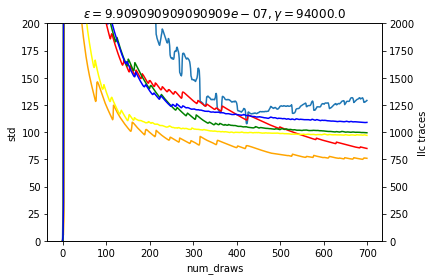

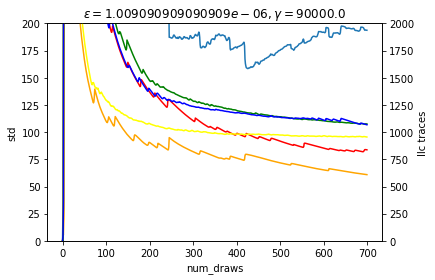

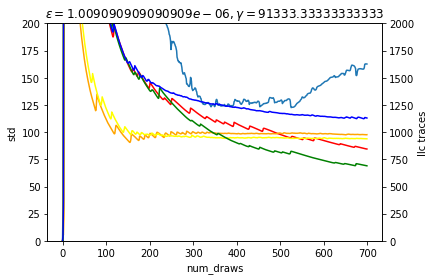

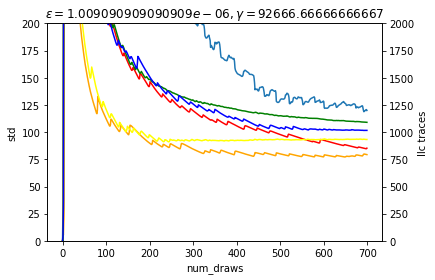

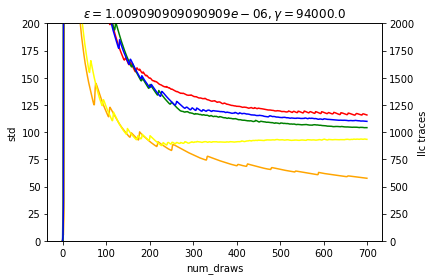

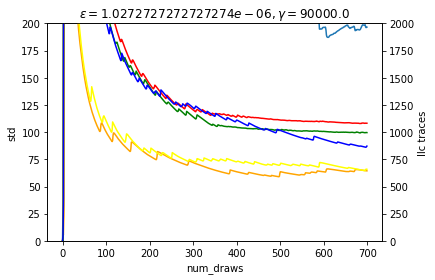

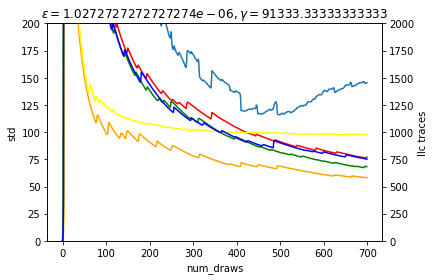

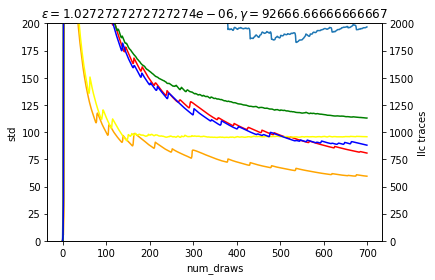

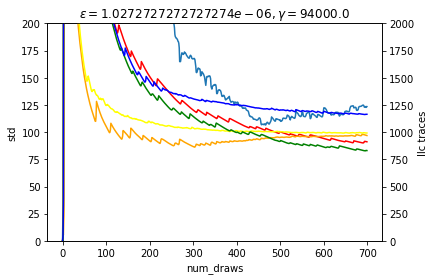

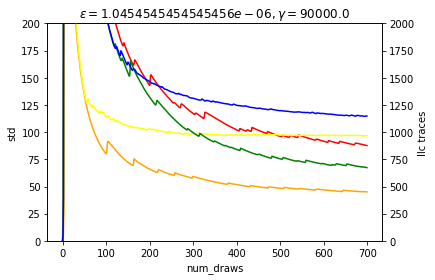

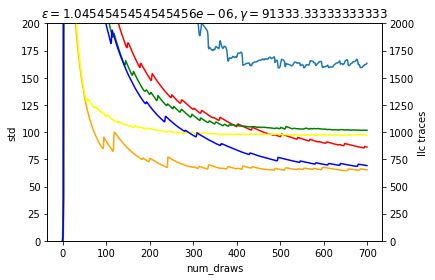

In [ ]:
smallest_std = +np.inf
best_result = None
best_key = None
for result in results:
    for key, value in result.items():
        # print(value["llc/trace"].shape)
        plt.plot(value["llc/stds"])
        plt.ylim(0, 200)
        plt.title(f"$\epsilon = {key[0]}, \gamma = {key[1]}$")
        plt.xlabel("num_draws")
        plt.ylabel("std")
        ax2 = plt.twinx()
        ax2.plot(value["llc/trace"][0], color="red")
        ax2.plot(value["llc/trace"][1], color="orange")
        ax2.plot(value["llc/trace"][2], color="yellow")
        ax2.plot(value["llc/trace"][3], color="green")
        ax2.plot(value["llc/trace"][4], color="blue")
        ax2.set_ylabel("llc traces")
        ax2.set_ylim(0, 2000)
        plt.show()

        if value["llc/stds"][-1] < smallest_std:
            smallest_std = value["llc/stds"][-1]
            best_result = value
            best_key = key

In [10]:
print(f"Best key: {best_key}, smallest std: {smallest_std}")

Best key: (9.181818181818181e-07, 94000.0), smallest std: 24.478761672973633


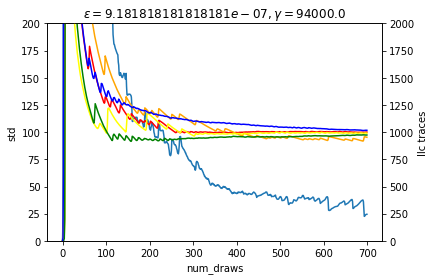

In [11]:
for result in results:
    for key, value in result.items():
        if key == best_key:
            plt.plot(value["llc/stds"])
            plt.ylim(0, 200)
            plt.title(f"$\epsilon = {key[0]}, \gamma = {key[1]}$")
            plt.xlabel("num_draws")
            plt.ylabel("std")
            ax2 = plt.twinx()
            ax2.plot(value["llc/trace"][0], color="red")
            ax2.plot(value["llc/trace"][1], color="orange")
            ax2.plot(value["llc/trace"][2], color="yellow")
            ax2.plot(value["llc/trace"][3], color="green")
            ax2.plot(value["llc/trace"][4], color="blue")
            ax2.set_ylabel("llc traces")
            ax2.set_ylim(0, 2000)
            plt.show()


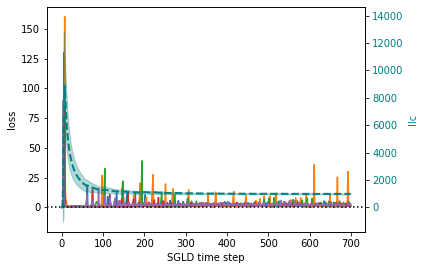

In [12]:
lah.plot_single_graph(best_result) 